In [242]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

plt.style.use([
    'grid',
    'notebook'
])

In [243]:
Ts = 1

sim_time = 2500
iterations = int(sim_time / Ts)

time = np.arange(0, sim_time, Ts)

r = 31
mu = 40
sigma = 55
A2 = np.pi * r**2

In [244]:
def M1(Z1):
    return 9150719.71133393*Z1 - 5877.32808711319


def N1(Z2):
    return 82.0022562085844*Z2 - 0.102477227864807


def P1(Z3):
    return 0.000587307446605506*Z3 + 0.985156412531603


def M2(Z1):
    return 1 - M1(Z1)


def N2(Z2):
    return 1 - N1(Z2)


def P2(Z3):
    return 1 - P1(Z3)


pertinence_functions = np.array([
    [M1, M2],
    [N1, N2],
    [P1, P2]
])

In [245]:
k1, k2, k3 = 1.04*(16.46), 0.95*(32.4), 0.93*(185.48)
b2, b3 = 0.95*(-83.93), 0.93*(-167.01)

/tmp/ipykernel_4265/2469162491.py:27: RuntimeWarning: invalid value encountered in sqrt
  q0 = .965*(k3 * np.sqrt(h1) + b3)


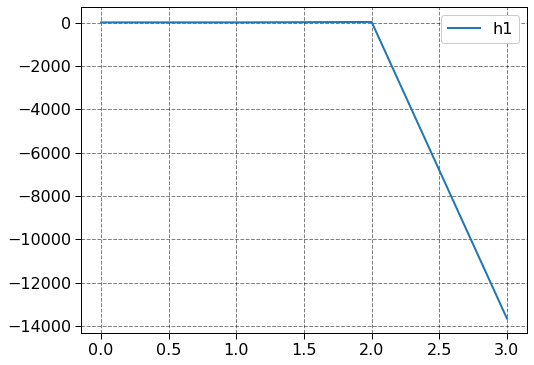

In [247]:
h1_t = np.zeros(iterations)
h2_t = np.zeros(iterations)

h1_0 = 18.
h2_0 = 20.

h1_t[0] = h1_0
h2_t[0] = h2_0

h1 = h1_0
h2 = h2_0

n = 8

A_matrices = [np.load(f'./vertices/A_{i}.npy') for i in range(n)]
B_matrices = [np.load(f'./vertices/B_{i}.npy') for i in range(n)]

u = 0

for i in range(1, iterations):
    diff = h2 - h1

    R12 = (k2*diff + b2)
    if diff < 5:
        R12 = 74.38

    q0 = .965*(k3 * np.sqrt(h1) + b3)

    l2 = np.cos(2.5*np.pi * (h1 - mu)) / (sigma * np.sqrt(2 * np.pi))
    l3 = np.exp(-((h1 - mu)**2) / (2 * sigma**2))

    A1 = ((3*r)/5) * (2.7*r - (l2 * l3))

    Z1 = 1/A1
    Z2 = 1/R12
    Z3 = q0/h2
    
    h1_t[i] = h1
    h2_t[i] = h2

    h = np.array([
        [h1],
        [h2]
    ])

    v = np.array([
        [pertinence_functions[0, 0](Z1), pertinence_functions[0, 1](Z1)],
        [pertinence_functions[1, 0](Z2), pertinence_functions[1, 1](Z2)],
        [pertinence_functions[2, 0](Z3), pertinence_functions[2, 1](Z3)],
    ])

    weights = np.array([
        v[0, 0] * v[1, 0] * v[2, 0],
        v[0, 0] * v[1, 0] * v[2, 1],
        v[0, 0] * v[1, 1] * v[2, 0],
        v[0, 0] * v[1, 1] * v[2, 1],
        v[0, 1] * v[1, 0] * v[2, 0],
        v[0, 1] * v[1, 0] * v[2, 1],
        v[0, 1] * v[1, 1] * v[2, 0],
        v[0, 1] * v[1, 1] * v[2, 1],
    ])

    Ai = sum([A_matrices[j] * weights[j] for j in range(n)])
    Bi = sum([B_matrices[j] * weights[j] for j in range(n)])

    sys = (Ai@h + Bi*u) * Ts

    h1 += sys[0, 0]
    h2 += sys[1, 0]

plt.plot(time, h1_t, label='h1')
plt.legend()